In [1]:
#https://aidanrussellcom.wordpress.com/2019/01/14/pystan-tutorial-1/

In [2]:
import numpy as np
import pandas as pd
import stan as ps
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
from utils import get_data
np.random.seed(2024)
train, test = get_data(filepath="processed_data/full_data_secs.csv", size_train=1000, size_test=800)
# train = train[train["dist"] == "10K"]
train.to_csv("train.csv")

In [3]:
ols_model = smf.ols(formula="finish ~ total_pace + curr_pace + prop", data=train)  # np.exp(prop)
ols_fit = ols_model.fit()
print(ols_fit.summary())

                            OLS Regression Results                            
Dep. Variable:                 finish   R-squared:                       0.943
Model:                            OLS   Adj. R-squared:                  0.943
Method:                 Least Squares   F-statistic:                 4.403e+04
Date:                Sun, 09 Feb 2025   Prob (F-statistic):               0.00
Time:                        19:52:23   Log-Likelihood:                 4710.1
No. Observations:                8000   AIC:                            -9412.
Df Residuals:                    7996   BIC:                            -9384.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.2486      0.010    -24.176      0.0

In [4]:
# ols_fit.get_prediction(test).summary_frame(alpha=0.05)

In [5]:
! python pystan_code.py #2.5mins total: train=500

8000
start
Building: found in cache, done.
Sampling:   0%
Sampling:   1% (100/8000)
Sampling:   1% (101/8000)
Sampling:   3% (201/8000)
Sampling:   3% (202/8000)
Sampling:   4% (301/8000)
Sampling:   5% (400/8000)
Sampling:   6% (500/8000)
Sampling:   8% (600/8000)
Sampling:   9% (700/8000)
Sampling:  10% (800/8000)
Sampling:  11% (900/8000)
Sampling:  12% (1000/8000)
Sampling:  14% (1100/8000)
Sampling:  15% (1200/8000)
Sampling:  16% (1300/8000)
Sampling:  18% (1400/8000)
Sampling:  19% (1500/8000)
Sampling:  20% (1600/8000)
Sampling:  21% (1700/8000)
Sampling:  22% (1800/8000)
Sampling:  24% (1900/8000)
Sampling:  25% (2000/8000)
Sampling:  26% (2100/8000)
Sampling:  28% (2200/8000)
Sampling:  29% (2300/8000)
Sampling:  30% (2400/8000)
Sampling:  31% (2500/8000)
Sampling:  32% (2600/8000)
Sampling:  34% (2700/8000)
Sampling:  35% (2800/8000)
Sampling:  36% (2900/8000)
Sampling:  38% (3000/8000)
Sampling:  39% (3100/8000)
Sampling:  40% (3200/8000)
Sampling:  41% (3301/8000)
Sampling

In [6]:
import pandas as pd
stan_results = pd.read_csv("stan_results/ps_result.csv") #stan_results = pd.read_csv("ps_result5K.csv")

marks = ["5K", "10K", "15K", "20K", "25K", "30K", "35K", "40K"]
sep_results = {mk: pd.read_csv(f"stan_results/ps_result{mk}.csv") for mk in marks}
stan_results.describe()

,draws,lp__,accept_stat__,stepsize__,treedepth__,n_leapfrog__,divergent__,energy__,alpha,beta.1,beta.2,beta.3,sigma
count,4000.000000,4000.000000,4000.000000,4000.000000,4000.00000,4000.000000,4000.0,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000
mean,1999.500000,12057.038265,0.937644,0.026028,6.42300,122.984500,0.0,-12054.541702,-0.248759,0.705087,0.290466,0.315215,0.134356
std,1154.844867,1.639153,0.089683,0.001799,1.00091,57.970172,0.0,2.300926,0.010185,0.012866,0.011973,0.006661,0.001102
min,0.000000,12046.192372,0.317368,0.023204,1.00000,1.000000,0.0,-12059.080622,-0.288747,0.663051,0.245798,0.293009,0.130668
25%,999.750000,12056.214245,0.913812,0.025099,6.00000,87.000000,0.0,-12056.217556,-0.255172,0.696452,0.282190,0.310791,0.133599
50%,1999.500000,12057.381755,0.975200,0.026649,7.00000,127.000000,0.0,-12054.905495,-0.248803,0.705364,0.290298,0.315407,0.134331
75%,2999.250000,12058.226318,0.996800,0.027578,7.00000,127.000000,0.0,-12053.264026,-0.241996,0.713959,0.298573,0.319696,0.135099
max,3999.000000,12059.516225,1.000000,0.027612,8.00000,255.000000,0.0,-12042.567338,-0.215513,0.749221,0.332169,0.338122,0.139033


In [7]:
pd.DataFrame([sep_results[mk][["alpha", "beta.1", "beta.2", "sigma"]].mean() for mk in marks])

,alpha,beta.1,beta.2,sigma
0,-0.253600,1.498219,-0.478779,0.210583
1,-0.174760,-0.315213,1.310351,0.174108
2,-0.136911,-0.158940,1.152171,0.152327
3,-0.013540,0.082077,0.891763,0.123176
4,0.030608,0.317004,0.647901,0.091550
5,0.089950,0.540963,0.428703,0.062082
6,0.063249,0.768970,0.215011,0.037761
7,0.018218,0.928482,0.066630,0.015630


In [8]:
def full_predictions(test_data, stan_data, name="stan_pred"):
    test_new = test_data.copy()
    d1 = test_new[feats]
    d2 = stan_data[betas].T.copy()
    preds = (stan_data["alpha"] + d1.dot(d2.values))#.mean(axis=1)
    # test_new[name] = preds
    return preds#test_new

def get_predictions(test_data, stan_data, name="stan_pred"):
    test_new = test_data.copy()
    d1 = test_new[feats]
    d2 = stan_data[betas].T.copy()
    preds = (stan_data["alpha"] + d1.dot(d2.values)).mean(axis=1)
    test_new[name] = preds
    return test_new

def get_table(test_data, old="stan_pred", new="stan"):
    y_true = (42195 / 60) / test_data["finish"]
    preds = (42195 / 60) / test_data[old]
    extrap = (42195 / 60) / test_data["total_pace"]
    test_data[new] = preds - y_true
    test_data["extrap"] = extrap - y_true
    return test_data

In [9]:
betas = ["beta.1", "beta.2", "beta.3"]
feats = ["total_pace", "curr_pace", "prop"]
test_pred = get_predictions(test, stan_results)


betas = ["beta.1", "beta.2"]
feats = ["total_pace", "curr_pace"]
test_pred2 = pd.concat([get_predictions(test_pred[test_pred["dist"] == mk], sep_results[mk]) for mk in marks])

In [10]:
table = get_table(test_pred).copy()
table["stan_sep"] = get_table(test_pred2)["stan"]
table

,id,dist,curr_pace,total_pace,finish,age,gender,year,prop,stan_pred,stan,extrap,stan_sep
28,286805,5K,5.154639,5.154639,5.018435,31,M,2023,0.118497,4.920308,2.794718,-3.702833,0.481619
71,286848,5K,4.677268,4.677268,4.851115,29,F,2023,0.118497,4.445060,13.242667,5.388183,10.805877
85,286862,5K,4.897160,4.897160,4.806904,30,M,2023,0.118497,4.663973,4.483451,-2.696350,2.103763
120,286897,5K,5.117707,5.117707,4.720855,41,M,2023,0.118497,4.883540,-4.962526,-11.551617,-7.285122
125,286902,5K,4.616805,4.616805,4.707687,23,M,2023,0.118497,4.384866,10.997860,2.940617,8.545445
...,...,...,...,...,...,...,...,...,...,...,...,...,...
208126,312707,40K,1.631321,1.960977,1.956008,27,F,2023,0.947980,1.906560,9.324629,-0.910996,1.543894
208138,312719,40K,1.728310,1.967439,1.951665,56,F,2023,0.947980,1.939289,2.299616,-2.888940,-1.551855
208148,312729,40K,1.693193,1.959728,1.943664,60,M,2023,0.947980,1.923652,3.764101,-2.965773,-1.287898
208150,312731,40K,1.431434,1.968310,1.942322,64,M,2023,0.947980,1.853671,17.315671,-4.780504,0.221377


In [11]:
test_pred

,id,dist,curr_pace,total_pace,finish,age,gender,year,prop,stan_pred,stan,extrap
28,286805,5K,5.154639,5.154639,5.018435,31,M,2023,0.118497,4.920308,2.794718,-3.702833
71,286848,5K,4.677268,4.677268,4.851115,29,F,2023,0.118497,4.445060,13.242667,5.388183
85,286862,5K,4.897160,4.897160,4.806904,30,M,2023,0.118497,4.663973,4.483451,-2.696350
120,286897,5K,5.117707,5.117707,4.720855,41,M,2023,0.118497,4.883540,-4.962526,-11.551617
125,286902,5K,4.616805,4.616805,4.707687,23,M,2023,0.118497,4.384866,10.997860,2.940617
...,...,...,...,...,...,...,...,...,...,...,...,...
208126,312707,40K,1.631321,1.960977,1.956008,27,F,2023,0.947980,1.906560,9.324629,-0.910996
208138,312719,40K,1.728310,1.967439,1.951665,56,F,2023,0.947980,1.939289,2.299616,-2.888940
208148,312729,40K,1.693193,1.959728,1.943664,60,M,2023,0.947980,1.923652,3.764101,-2.965773
208150,312731,40K,1.431434,1.968310,1.942322,64,M,2023,0.947980,1.853671,17.315671,-4.780504


         extrap       stan   stan_sep
dist                                 
5K    18.266615  16.717774  15.751885
10K   17.293082  12.853463  12.566208
15K   15.891527  10.660281  10.121789
20K   13.460085   8.463114   9.669722
25K   11.258575   6.598435   6.327381
30K    7.920076   4.668593   4.384322
35K    4.376820   3.984873   2.754150
40K    1.179431   4.014930   0.904723


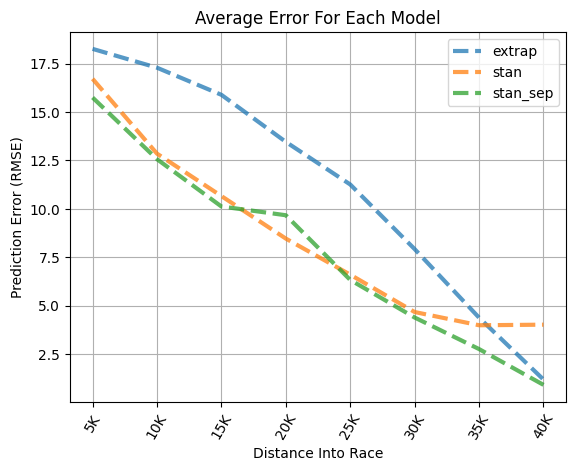

In [12]:
labels = ["extrap", "stan", "stan_sep"]#, "bayes2", "quant1", "quant2"]
colors = ["C0", "C1", "C2"]#, "C3", "C4"]
styles = '--'
mks = ["5K", "10K", "15K", "20K", "25K", "30K", "35K", "40K"]
table = table.groupby(["dist"])[labels].apply(lambda x: (x ** 2).mean() ** 0.5).loc[mks]
print(table)
table.plot(label=table.columns,  style=styles, linewidth=3, grid=True, alpha=0.75, color=colors)

plt.xlabel("Distance Into Race")
plt.ylabel("Prediction Error (RMSE)")
plt.xticks(rotation=60)
plt.title("Average Error For Each Model")
plt.grid(True)
plt.legend()
# plt.savefig("analysis/all_errors.png", bbox_inches="tight")

In [13]:
full_preds =  (42195 / 60) / full_predictions(test, stan_results)

In [14]:
np.percentile(full_preds, [10, 25, 50, 75, 90], axis=1)#.shape

array([[143.79876019, 159.32165373, 151.7734197 , ..., 430.67009772,
        449.21975625, 446.95929062],
       [143.90350832, 159.42902276, 151.88109324, ..., 431.74528111,
        450.67023351, 447.90661709],
       [144.02331958, 159.55325966, 152.00314689, ..., 432.80842356,
        452.29685563, 448.99100009],
       [144.14201739, 159.67337239, 152.12212587, ..., 433.91794444,
        453.94048167, 450.08875874],
       [144.2454528 , 159.77623362, 152.22643582, ..., 434.95306671,
        455.40675535, 451.12410186]])

In [15]:
# import arviz as az
# idata = az.from_netcdf("save_idata.nc")